<a href="https://colab.research.google.com/github/tjdrhks0808/Project-Road_Accident/blob/main/Daejeon_GWR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모델링
> __종속변수에 미치는 독립변수의 영향을 더 잘 보기 위해 회귀분석을 진행__  
> __OLS, SEM, SLM, GWR과 같은 다양한 회귀 및 공간회귀 모형 적합__

## 데이터 및 패키지 불러오기  
> __분석에 필요한 패키지 및 데이터를 불러온 뒤 추가적인 데이터 정제 진행__

In [ ]:
from geoband.API import *

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import json
import geopandas as gpd
import os
import pydeck as pdk
import shapefile

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:91: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [ ]:
#변수선택법

import time
import itertools

In [ ]:
#회귀분석

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#공간회귀분석

import pysal
import libpysal
from esda.moran import Moran
from esda.moran import Moran_Local
from libpysal.weights import Queen, Rook, KNN, DistanceBand, Kernel
from esda.getisord import G
from esda.moran import Moran
from spreg import OLS, ML_Lag, ML_Error, GM_Lag, GM_Error, TSLS

In [ ]:
#정규성검정

from scipy.stats import shapiro

In [ ]:
#다중공선성 체크

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
#지리적가중회귀분석

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap

In [ ]:
#전처리 및 정제 단계에서 생성된 daejeon_data를 불러온 뒤 분석을 위해 도로인 격자만 추출

daejeon_data = gpd.read_file('daejeon_data.geojson')

daejeon_data = sm.add_constant(daejeon_data, has_constant='add')

daejeon_data = daejeon_data[daejeon_data['isroad'] == 1]

daejeon_data = daejeon_data.reset_index()

del daejeon_data['index']

daejeon_data = gpd.GeoDataFrame(daejeon_data)

In [ ]:
from tqdm import tqdm

In [ ]:
#parklinglot_cnt, school_cnt, ssm_cnt 변수를 범주형으로 변환

for i in tqdm(range(len(daejeon_data))) :
    if daejeon_data.parkinglot_cnt[i] > 0 :
        daejeon_data.parkinglot_cnt[i] = 1
    if daejeon_data.school_cnt[i] > 0 :
        daejeon_data.school_cnt[i] = 1
    if daejeon_data.ssm_cnt[i] > 0 :
        daejeon_data.ssm_cnt[i] = 1

  0%|          | 0/15347 [00:00<?, ?it/s]/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
100%|██████████| 

In [ ]:
#width4 와 width5 변수를 하나로 합친 뒤 모든 width변수를 범주형 변수로 변환

for i in tqdm(range(len(daejeon_data))) :
    x = np.array([daejeon_data.width_1[i], daejeon_data.width_2[i], daejeon_data.width_3[i], daejeon_data.width_4[i], daejeon_data.width_5[i]])
    max_idx = x.argmax()
    if max_idx == 0 :
        daejeon_data.width_1[i] = 1
        daejeon_data.width_2[i] = 0
        daejeon_data.width_3[i] = 0
        daejeon_data.width_4[i] = 0
        daejeon_data.width_5[i] = 0
    elif max_idx == 1 :
        daejeon_data.width_1[i] = 0
        daejeon_data.width_2[i] = 1
        daejeon_data.width_3[i] = 0
        daejeon_data.width_4[i] = 0
        daejeon_data.width_5[i] = 0
    elif max_idx == 2 :
        daejeon_data.width_1[i] = 0
        daejeon_data.width_2[i] = 0
        daejeon_data.width_3[i] = 1
        daejeon_data.width_4[i] = 0
        daejeon_data.width_5[i] = 0
    elif max_idx == 3 :
        daejeon_data.width_1[i] = 0
        daejeon_data.width_2[i] = 0
        daejeon_data.width_3[i] = 0
        daejeon_data.width_4[i] = 1
        daejeon_data.width_5[i] = 0
    elif max_idx == 4 :
        daejeon_data.width_1[i] = 0
        daejeon_data.width_2[i] = 0
        daejeon_data.width_3[i] = 0
        daejeon_data.width_4[i] = 1
        daejeon_data.width_5[i] = 0

  0%|          | 0/15347 [00:00<?, ?it/s]/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.p

In [ ]:
#모든 speed변수를 범주형 변수로 변환

for i in tqdm(range(len(daejeon_data))) :
    x = np.array([daejeon_data.speed_0[i], daejeon_data.speed_30[i], daejeon_data.speed_40_to_50[i], daejeon_data.speed_60_to_70[i], daejeon_data.speed_80_to_110[i]])
    max_idx = x.argmax()
    if max_idx == 0 :
        daejeon_data.speed_0[i] = 1
        daejeon_data.speed_30[i] = 0
        daejeon_data.speed_40_to_50[i] = 0
        daejeon_data.speed_60_to_70[i] = 0
        daejeon_data.speed_80_to_110[i] = 0
    elif max_idx == 1 :
        daejeon_data.speed_0[i] = 0
        daejeon_data.speed_30[i] = 1
        daejeon_data.speed_40_to_50[i] = 0
        daejeon_data.speed_60_to_70[i] = 0
        daejeon_data.speed_80_to_110[i] = 0
    elif max_idx == 2 :
        daejeon_data.speed_0[i] = 0
        daejeon_data.speed_30[i] = 0
        daejeon_data.speed_40_to_50[i] = 1
        daejeon_data.speed_60_to_70[i] = 0
        daejeon_data.speed_80_to_110[i] = 0
    elif max_idx == 3 :
        daejeon_data.speed_0[i] = 0
        daejeon_data.speed_30[i] = 0
        daejeon_data.speed_40_to_50[i] = 0
        daejeon_data.speed_60_to_70[i] = 1
        daejeon_data.speed_80_to_110[i] = 0
    elif max_idx == 4 :
        daejeon_data.speed_0[i] = 0
        daejeon_data.speed_30[i] = 0
        daejeon_data.speed_40_to_50[i] = 0
        daejeon_data.speed_60_to_70[i] = 0
        daejeon_data.speed_80_to_110[i] = 1

  0%|          | 0/15347 [00:00<?, ?it/s]/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/app-root/lib/py

## 변수선택법 정의
> __이후 분석을 위해 전진선택법, 후진제거법, 단계선택법의 세 가지 동류의 변수선택법 정의__   
> __이를 사용하여 가장 좋은 회귀 모형을 도출__

In [ ]:
def processSubset(X,y,feature_set):
    model = sm.OLS(y,X[list(feature_set)]) # Modeling
    regr = model.fit() # model fitting
    AIC = regr.aic # model's AIC
    return {"model" : regr, "AIC" : AIC}

In [ ]:
#전진선택법

def forward(X,y,predictors):

    # predictor - 현재 선택되어있는 변수
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors :
        results.append(processSubset(X=X,y=y,feature_set=predictors+[p]+['const']))
    
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['AIC'].argmin()] #AIC가 가장 낮은 모델을 선택
    toc = time.time()
    print("Processed ",models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print("Selected predictors:",best_model["model"].model.exog_names,"AIC: ",best_model[0])
    return best_model
    
#전진선택법 모델

def forward_model(X,y):

    Fmodels = pd.DataFrame(columns=["AIC","model"])
    tic = time.time()
     
    predictors = []
    
    for i in range(1,len(X.columns.difference(['const']))+1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1:
            if Forward_result["AIC"] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:",(toc-tic), "seconds.")
    
    return (Fmodels['model'][len(Fmodels['model'])])

In [ ]:
#후진제거법

def backward(X,y,predictors):
    tic= time.time()
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X,y=y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['AIC'].argmin()]    # 가장 낮은 AIC를 가진 모델을 선택
    toc = time.time()
    
    print("Processed ",models.shape[0], "models on", len(predictors) - 1, "predictors in",(toc-tic))
    print("Selected predictors:",best_model['model'].model.exog_names,' AIC:',best_model[0])
    return best_model
    
def backward_model(X,y) :
    Bmodels = pd.DataFrame(columns=["AIC","model"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=X, y= y, predictors=predictors)
        if Backward_result['AIC'] > Bmodel_before :
            break
        Bmodels.loc[len(predictors) -1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]['model'].model.exog_names
        Bmodel_before = Backward_result["AIC"]
        predictors = [k for k in predictors if k != 'const']

    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return Bmodels["model"].dropna().iloc[0]

In [ ]:
#변수선택법

def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns = ["AIC","model"])
    tic = time.time()
    predictors = []
    Smodel_before = processSubset(X,y,predictors + ['const'])['AIC']
    
    
    for i in range(1,len(X.columns.difference(['const']))+1) :
        Forward_result = forward(X=X,y=y,predictors = predictors) # constant added
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]["model"].model.exog_names
        predictors = [k for k in predictors if k != 'const']
        Backward_result = backward(X=X,y=y,predictors = predictors)
        if Backward_result["AIC"] < Forward_result["AIC"]:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            Smodel_before = Stepmodels.loc[i]["AIC"]
            predictors = [k for k in predictors if k != "const"]
            print('backward')
        if Stepmodels.loc[i]["AIC"] > Smodel_before:
            break
        else :
            Smodel_before = Stepmodels.loc[i]["AIC"]
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return (Stepmodels["model"][len(Stepmodels["model"])])

## 데이터셋 정의
> __데이터 전처리 결과 생성된 모든 독립변수 및 종속변수 정의__

In [ ]:
#전체 독립변수

X = daejeon_data[['const', 'traffic_total_sum_inter', 'oneway', 'car_lane', 'barrier_road',
       'speed_0', 'speed_30', 'express', 'general', 'width_1', 'width_2',
       'width_3', 'width_4', 'freq_max_inter', 'time_max_inter',
       'intersects', 'TURN_P', 'building_tot', 'house', 'office', 'other',
       'crosswalk_ar', 'noparking_ar', 'trlight_pas', 'trlight_car', 'cctv',
       'sign_traffic', 'safe_zone', 'pop_all', 'pop_sen', 'pop_prd', 'pop_chd',
       'cars_cnt', 'subway_cnt', 'parkinglot_cnt', 'school_cnt', 'ssm_cnt',
       'restaurant_cnt', 'speed_40_to_50', 'speed_60_to_70', 'speed_80_to_110']]

In [ ]:
#EPDO방식 위험도와 교통량 대비 사고를 종속변수로 정의
#차대차, 차대사람, 차량단독 및 모든 사고유형을 고려

y_acc_risk_ctc = pd.DataFrame(daejeon_data.loc[:, 'acci_risk_ctc'])

y_acc_risk_cth = pd.DataFrame(daejeon_data.loc[:, 'acci_risk_cth'])

y_acc_risk_cal = pd.DataFrame(daejeon_data.loc[:, 'acci_risk_cal'])

y_acc_risk = pd.DataFrame(daejeon_data.loc[:, 'acci_risk'])

y_acc_ratio_ctc = pd.DataFrame(daejeon_data.loc[:, 'acci_ratio_ctc'])

y_acc_ratio_cth = pd.DataFrame(daejeon_data.loc[:, 'acci_ratio_cth'])

y_acc_ratio_cal = pd.DataFrame(daejeon_data.loc[:, 'acci_ratio_cal'])

y_acc_ratio = pd.DataFrame(daejeon_data.loc[:, 'acci_ratio'])

## 다중공선성 제거
> __독립변수를 대상으로 다중공선성 확인 후 처리__

In [ ]:
#전체 독립변수를 대상으로 다중공선성 확인

vif_acc_risk = pd.DataFrame()
vif_acc_risk['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_acc_risk['features'] = X.columns
vif_acc_risk

/opt/app-root/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/app-root/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF Factor                 features
0      0.000000                    const
1      3.303356  traffic_total_sum_inter
2      2.511829                   oneway
3      4.275803                 car_lane
4      1.475671             barrier_road
5           inf                  speed_0
6           inf                 speed_30
7      4.543991                  express
8      3.395102                  general
9           inf                  width_1
10          inf                  width_2
11          inf                  width_3
12          inf                  width_4
13     9.667822           freq_max_inter
14     9.672729           time_max_inter
15          inf               intersects
16          inf                   TURN_P
17          inf             building_tot
18          inf                    house
19          inf                   office
20          inf                    other
21     4.134152             crosswalk_ar
22     1.018017             noparking_ar
23     5.547122              trlight_pas
24     4.959339              trlight_car
25     1.123976                     cctv
26     2.497132             sign_traffic
27     1.485025                safe_zone
28  9185.087001                  pop_all
29   264.800800                  pop_sen
30  4959.538869                  pop_prd
31   188.653284                  pop_chd
32     1.123550                 cars_cnt
33     1.036576               subway_cnt
34     1.064105           parkinglot_cnt
35     1.016491               school_cnt
36     1.096766                  ssm_cnt
37     1.431368           restaurant_cnt
38          inf           speed_40_to_50
39          inf           speed_60_to_70
40          inf          speed_80_to_110

In [ ]:
#다중공선성 확인 후 다중공선성이 제거된 독립변수

X = daejeon_data[['const', 'traffic_total_sum_inter', 'oneway', 'car_lane', 'barrier_road',
       'speed_0', 'speed_30', 'express', 'width_1', 'width_2',
       'width_3', 'freq_max_inter',
       'intersects', 'house', 'office', 'other',
       'crosswalk_ar', 'noparking_ar', 'trlight_pas', 'trlight_car', 'cctv',
       'sign_traffic', 'safe_zone', 'pop_all',
       'cars_cnt', 'subway_cnt', 'parkinglot_cnt', 'school_cnt', 'ssm_cnt',
       'restaurant_cnt', 'speed_40_to_50', 'speed_60_to_70']]

In [ ]:
vif_acc_risk = pd.DataFrame()
vif_acc_risk['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_acc_risk['features'] = X.columns
vif_acc_risk

VIF Factor                 features
0    32.322495                    const
1     2.878312  traffic_total_sum_inter
2     2.382765                   oneway
3     4.256322                 car_lane
4     1.463425             barrier_road
5     4.773934                  speed_0
6     1.857507                 speed_30
7     4.214477                  express
8     3.531450                  width_1
9     4.141995                  width_2
10    2.669204                  width_3
11    1.562114           freq_max_inter
12    1.497057               intersects
13    1.284641                    house
14    1.242936                   office
15    1.610445                    other
16    3.978941             crosswalk_ar
17    1.017570             noparking_ar
18    5.540002              trlight_pas
19    4.955860              trlight_car
20    1.122188                     cctv
21    2.432029             sign_traffic
22    1.473673                safe_zone
23    1.298385                  pop_all
24    1.120174                 cars_cnt
25    1.035575               subway_cnt
26    1.062775           parkinglot_cnt
27    1.014526               school_cnt
28    1.095148                  ssm_cnt
29    1.368209           restaurant_cnt
30    4.903039           speed_40_to_50
31    4.254763           speed_60_to_70

In [ ]:
#독립변수들의 계수의 크기를 명확히 비교하기 위해 독립변수를 대상으로 Min-Max scaling 진행

scaler = MinMaxScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

scaled_X = pd.DataFrame(scaled_X)
scaled_X.columns = list(X.columns)

del scaled_X['const']
scaled_X = sm.add_constant(scaled_X, has_constant='add')

scaled_X

const  traffic_total_sum_inter    oneway  car_lane  barrier_road  \
0        1.0                 0.033855  0.000000  0.000000      0.142857   
1        1.0                 0.019318  0.000000  0.000000      0.000000   
2        1.0                 0.061862  0.000000  0.000000      0.000000   
3        1.0                 0.047397  0.000000  0.000000      0.142857   
4        1.0                 0.011098  0.000000  0.000000      0.000000   
...      ...                      ...       ...       ...           ...   
15342    1.0                 0.107516  0.066667  0.333333      0.142857   
15343    1.0                 0.058917  0.133333  0.333333      0.000000   
15344    1.0                 0.043612  0.066667  0.166667      0.000000   
15345    1.0                 0.003761  0.000000  0.000000      0.000000   
15346    1.0                 0.116680  0.133333  0.333333      0.000000   

       speed_0  speed_30  express  width_1  width_2  ...  safe_zone   pop_all  \
0          1.0       0.0      0.0      0.0      0.0  ...   0.000000  0.004788   
1          0.0       0.0      0.0      0.0      0.0  ...   0.111111  0.098343   
2          0.0       1.0      0.0      0.0      1.0  ...   0.000000  0.028729   
3          0.0       0.0      0.0      0.0      0.0  ...   0.055556  0.000000   
4          1.0       0.0      0.0      0.0      0.0  ...   0.000000  0.145856   
...        ...       ...      ...      ...      ...  ...        ...       ...   
15342      0.0       0.0      0.0      0.0      0.0  ...   0.000000  0.000000   
15343      0.0       0.0      0.2      0.0      0.0  ...   0.000000  0.000000   
15344      0.0       0.0      0.1      0.0      1.0  ...   0.000000  0.000000   
15345      0.0       0.0      0.0      0.0      1.0  ...   0.000000  0.000000   
15346      0.0       0.0      0.2      0.0      1.0  ...   0.000000  0.000000   

       cars_cnt  subway_cnt  parkinglot_cnt  school_cnt  ssm_cnt  \
0      0.000822         0.0             0.0         0.0      0.0   
1      0.000000         0.0             0.0         0.0      0.0   
2      0.008215         0.0             0.0         0.0      0.0   
3      0.084001         0.0             0.0         0.0      0.0   
4      0.000000         0.0             0.0         0.0      0.0   
...         ...         ...             ...         ...      ...   
15342  0.000000         0.0             0.0         0.0      0.0   
15343  0.000000         0.0             0.0         0.0      0.0   
15344  0.000000         0.0             0.0         0.0      0.0   
15345  0.000000         0.0             0.0         0.0      0.0   
15346  0.000000         0.0             0.0         0.0      0.0   

       restaurant_cnt  speed_40_to_50  speed_60_to_70  
0                 0.0             0.0             0.0  
1                 0.0             1.0             0.0  
2                 0.0             0.0             0.0  
3                 0.0             0.0             1.0  
4                 0.0             0.0             0.0  
...               ...             ...             ...  
15342             0.0             0.0             0.0  
15343             0.0             0.0             0.0  
15344             0.0             0.0             0.0  
15345             0.0             1.0             0.0  
15346             0.0             0.0             0.0  

[15347 rows x 32 columns]

## 최적 ols 모델 도출
> __다중공선성이 완전히 제거된 독립변수들을 사용__  
> __종속변수를 차대차, 차대사람, 차량단독으로 하여 세 가지 OLS모형 적합__  
> __단계선택법을 통해 각 모형 별로 최적 모델 도출__

### 사고 위험도 모델

In [ ]:
step_best_model_ctc = Stepwise_model(scaled_X, y_acc_risk_ctc)

Processed  31 models on 1 predictors in 0.6893322467803955
Selected predictors: ['traffic_total_sum_inter', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50c7a7cd30>
forward
Processed  1 models on 0 predictors in 0.004715681076049805
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50c2519860>
Processed  30 models on 2 predictors in 0.8920135498046875
Selected predictors: ['traffic_total_sum_inter', 'crosswalk_ar', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50c279ff98>
forward
Processed  2 models on 1 predictors in 0.09791445732116699
Selected predictors: ['traffic_total_sum_inter', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50c7a7c128>
Processed  29 models on 3 predictors in 0.9024045467376709
Selected predictors: ['traffic_total_sum_inter', 'crosswalk_ar', 'car_lane', 'const'] AIC: 

In [ ]:
step_best_model_ctc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          acci_risk_ctc   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     806.2
Date:                Wed, 31 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:18:10   Log-Likelihood:                -40101.
No. Observations:               15347   AIC:                         8.025e+04
Df Residuals:                   15323   BIC:                         8.043e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
traffic_total_sum_inter    35.5097      0.557     63.795      0.000      34.419      36.601
crosswalk_ar               11.4096      0.474     24.069      0.000      10.480      12.339
car_lane                   -6.3948      0.479    -13.357      0.000      -7.333      -5.456
cctv                       10.0504      0.458     21.935      0.000       9.152      10.949
restaurant_cnt              4.0400      0.452      8.947      0.000       3.155       4.925
subway_cnt                  4.1899      0.433      9.667      0.000       3.340       5.039
trlight_car                 5.1424      0.562      9.151      0.000       4.041       6.244
safe_zone                  -3.4077      0.724     -4.707      0.000      -4.827      -1.989
office                      3.1866      0.658      4.846      0.000       1.898       4.475
barrier_road               -2.4670      0.358     -6.883      0.000      -3.169      -1.764
oneway                     -3.7008      0.516     -7.176      0.000      -4.712      -2.690
speed_40_to_50              0.1522      0.073      2.096      0.036       0.010       0.295
width_1                     0.8749      0.096      9.111      0.000       0.687       1.063
intersects                  1.6834      0.354      4.760      0.000       0.990       2.377
width_2                     0.4965      0.069      7.218      0.000       0.362       0.631
trlight_pas                -2.2244      0.552     -4.029      0.000      -3.306      -1.142
other                       3.3218      0.727      4.567      0.000       1.896       4.748
express                    -1.9817      0.681     -2.912      0.004      -3.316      -0.648
freq_max_inter             -0.3925      0.096     -4.076      0.000      -0.581      -0.204
pop_all                     1.4821      0.514      2.884      0.004       0.475       2.489
speed_30                   -0.3670      0.134     -2.748      0.006      -0.629      -0.105
noparking_ar                3.1198      1.745      1.788      0.074      -0.300       6.539
speed_60_to_70             -0.1236      0.083     -1.490      0.136      -0.286       0.039
const                      -0.9769      0.093    -10.525      0.000      -1.159      -0.795
==============================================================================
Omnibus:                    15293.882   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2201556.999
Skew:                           4.550   Prob(JB):                         0.00
Kurtosis:                      60.966   Cond. No.                         88.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#종속변수를 차대차로 하여, 단계선택법으로 도출된 최적 모델에서 유의한 독립변수들 정의

X_ctc = scaled_X[['traffic_total_sum_inter', 'crosswalk_ar', 'car_lane', 'cctv', 'restaurant_cnt', 'subway_cnt', 'trlight_car',
'safe_zone', 'office', 'barrier_road', 'oneway', 'speed_40_to_50', 'width_1', 'intersects', 'width_2',
'trlight_pas', 'other', 'express', 'freq_max_inter', 'pop_all', 'speed_30', 'noparking_ar', 'const']]

In [ ]:
step_best_model_cth = Stepwise_model(scaled_X, y_acc_risk_cth)

Processed  31 models on 1 predictors in 0.9691097736358643
Selected predictors: ['restaurant_cnt', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50c274dd68>
forward
Processed  1 models on 0 predictors in 0.007905721664428711
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50c274def0>
Processed  30 models on 2 predictors in 1.7021160125732422
Selected predictors: ['restaurant_cnt', 'crosswalk_ar', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50c274d588>
forward
Processed  2 models on 1 predictors in 0.19448137283325195
Selected predictors: ['restaurant_cnt', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50c7a67668>
Processed  29 models on 3 predictors in 1.300173044204712
Selected predictors: ['restaurant_cnt', 'crosswalk_ar', 'other', 'const'] AIC:  <statsmodels.regression.linear_model.Re

In [ ]:
step_best_model_cth.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          acci_risk_cth   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     219.8
Date:                Wed, 31 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:19:43   Log-Likelihood:                -32242.
No. Observations:               15347   AIC:                         6.452e+04
Df Residuals:                   15328   BIC:                         6.467e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
restaurant_cnt              6.7564      0.273     24.755      0.000       6.221       7.291
crosswalk_ar                2.9800      0.247     12.067      0.000       2.496       3.464
other                       5.7734      0.437     13.220      0.000       4.917       6.629
traffic_total_sum_inter     4.5534      0.285     15.959      0.000       3.994       5.113
pop_all                     1.9247      0.307      6.267      0.000       1.323       2.527
car_lane                   -0.9486      0.186     -5.101      0.000      -1.313      -0.584
safe_zone                  -2.3756      0.424     -5.603      0.000      -3.207      -1.545
trlight_car                 0.8470      0.236      3.583      0.000       0.384       1.310
ssm_cnt                     0.3009      0.085      3.529      0.000       0.134       0.468
parkinglot_cnt              0.1817      0.065      2.816      0.005       0.055       0.308
speed_30                   -0.2049      0.076     -2.693      0.007      -0.354      -0.056
office                      1.1653      0.397      2.938      0.003       0.388       1.943
subway_cnt                  0.5890      0.260      2.268      0.023       0.080       1.098
oneway                     -0.7015      0.269     -2.609      0.009      -1.229      -0.174
cctv                        0.5788      0.273      2.117      0.034       0.043       1.115
noparking_ar                1.9119      1.044      1.832      0.067      -0.134       3.958
house                      -0.3038      0.159     -1.909      0.056      -0.616       0.008
speed_40_to_50              0.0671      0.036      1.881      0.060      -0.003       0.137
const                      -0.1333      0.028     -4.846      0.000      -0.187      -0.079
==============================================================================
Omnibus:                    23401.369   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         22787386.239
Skew:                           9.272   Prob(JB):                         0.00
Kurtosis:                     190.861   Cond. No.                         70.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#종속변수를 차대사람으로 하여, 단계선택법으로 도출된 최적 모델에서 유의한 독립변수들 정의

X_cth = scaled_X[['restaurant_cnt', 'crosswalk_ar', 'other', 'traffic_total_sum_inter', 'pop_all', 'car_lane', 'safe_zone', 'trlight_car',
'ssm_cnt', 'parkinglot_cnt', 'speed_30', 'office', 'subway_cnt', 'oneway', 'cctv', 'noparking_ar', 'house', 'speed_40_to_50', 'const']]

In [ ]:
step_best_model_cal = Stepwise_model(scaled_X, y_acc_risk_cal)

Processed  31 models on 1 predictors in 0.6751623153686523
Selected predictors: ['traffic_total_sum_inter', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50c2729eb8>
forward
Processed  1 models on 0 predictors in 0.09228181838989258
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50c2729ef0>
Processed  30 models on 2 predictors in 0.8074359893798828
Selected predictors: ['traffic_total_sum_inter', 'trlight_car', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50c798c2b0>
forward
Processed  2 models on 1 predictors in 0.09850668907165527
Selected predictors: ['traffic_total_sum_inter', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50c27264a8>
Processed  29 models on 3 predictors in 0.8969628810882568
Selected predictors: ['traffic_total_sum_inter', 'trlight_car', 'cctv', 'const'] AIC:  <stats

In [ ]:
step_best_model_cal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          acci_risk_cal   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     67.04
Date:                Wed, 31 Mar 2021   Prob (F-statistic):          1.50e-134
Time:                        21:20:54   Log-Likelihood:                -16949.
No. Observations:               15347   AIC:                         3.392e+04
Df Residuals:                   15336   BIC:                         3.400e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
traffic_total_sum_inter     1.2158      0.098     12.426      0.000       1.024       1.408
trlight_car                 0.3443      0.074      4.663      0.000       0.200       0.489
cctv                        0.6007      0.100      5.979      0.000       0.404       0.798
other                       0.7292      0.132      5.539      0.000       0.471       0.987
subway_cnt                  0.4914      0.096      5.131      0.000       0.304       0.679
express                    -0.3072      0.083     -3.683      0.000      -0.471      -0.144
noparking_ar               -0.9841      0.385     -2.556      0.011      -1.739      -0.229
school_cnt                  0.1053      0.043      2.471      0.013       0.022       0.189
width_2                    -0.0272      0.012     -2.209      0.027      -0.051      -0.003
sign_traffic                0.1160      0.076      1.529      0.126      -0.033       0.265
const                       0.0108      0.011      0.995      0.320      -0.010       0.032
==============================================================================
Omnibus:                    26228.396   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         21129398.473
Skew:                          12.012   Prob(JB):                         0.00
Kurtosis:                     183.182   Cond. No.                         74.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#종속변수를 차량단독으로 하여, 단계선택법으로 도출된 최적 모델에서 유의한 독립변수들 정의

X_cal = scaled_X[['traffic_total_sum_inter', 'trlight_car', 'cctv', 'other', 'subway_cnt', 'express', 'noparking_ar',
'school_cnt', 'width_2', 'const']]

### 사고확률 모델

In [ ]:
step_best_model_ctc_ratio = Stepwise_model(scaled_X, y_acc_ratio_ctc)

Processed  31 models on 1 predictors in 0.8915715217590332
Selected predictors: ['restaurant_cnt', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50d8fb1710>
forward
Processed  1 models on 0 predictors in 0.09259295463562012
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50c274df98>
Processed  30 models on 2 predictors in 0.8076121807098389
Selected predictors: ['restaurant_cnt', 'pop_all', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50c279f9e8>
forward
Processed  2 models on 1 predictors in 0.09591293334960938
Selected predictors: ['restaurant_cnt', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50c2732f98>
Processed  29 models on 3 predictors in 0.9057331085205078
Selected predictors: ['restaurant_cnt', 'pop_all', 'speed_0', 'const'] AIC:  <statsmodels.regression.linear_model.Regression

In [ ]:
step_best_model_ctc_ratio.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         acci_ratio_ctc   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     50.59
Date:                Wed, 31 Mar 2021   Prob (F-statistic):          2.52e-176
Time:                        21:35:52   Log-Likelihood:             1.0617e+05
No. Observations:               15347   AIC:                        -2.123e+05
Df Residuals:                   15328   BIC:                        -2.122e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
restaurant_cnt              0.0004   3.31e-05     11.294      0.000       0.000       0.000
pop_all                     0.0003   3.97e-05      7.893      0.000       0.000       0.000
speed_0                  2.587e-05   5.49e-06      4.714      0.000    1.51e-05    3.66e-05
house                    8.865e-05   1.95e-05      4.541      0.000    5.04e-05       0.000
crosswalk_ar                0.0002   3.56e-05      4.691      0.000    9.71e-05       0.000
width_1                  3.286e-05   6.22e-06      5.282      0.000    2.07e-05     4.5e-05
other                       0.0001   5.33e-05      2.512      0.012    2.95e-05       0.000
traffic_total_sum_inter    -0.0001   3.75e-05     -2.737      0.006      -0.000   -2.91e-05
freq_max_inter           2.302e-05   7.05e-06      3.266      0.001     9.2e-06    3.68e-05
office                      0.0001   4.81e-05      2.481      0.013     2.5e-05       0.000
sign_traffic             6.887e-05   2.74e-05      2.511      0.012    1.51e-05       0.000
trlight_pas             -5.677e-05   2.83e-05     -2.003      0.045      -0.000   -1.22e-06
parkinglot_cnt            1.36e-05   7.84e-06      1.735      0.083   -1.76e-06     2.9e-05
barrier_road            -4.607e-05   2.55e-05     -1.808      0.071    -9.6e-05    3.87e-06
oneway                  -7.597e-05   3.36e-05     -2.264      0.024      -0.000   -1.02e-05
car_lane                  3.51e-05   2.27e-05      1.545      0.122   -9.44e-06    7.96e-05
ssm_cnt                   1.58e-05   1.03e-05      1.530      0.126   -4.44e-06     3.6e-05
cars_cnt                -9.316e-05   6.35e-05     -1.468      0.142      -0.000    3.12e-05
const                    6.269e-08   3.96e-06      0.016      0.987   -7.71e-06    7.83e-06
==============================================================================
Omnibus:                    39917.240   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1391379223.554
Skew:                          29.939   Prob(JB):                         0.00
Kurtosis:                    1476.868   Cond. No.                         40.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
step_best_model_cth_ratio = Stepwise_model(scaled_X, y_acc_ratio_cth)

Processed  31 models on 1 predictors in 0.6843380928039551
Selected predictors: ['restaurant_cnt', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50c2534d30>
forward
Processed  1 models on 0 predictors in 0.09434843063354492
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50c2534ef0>
Processed  30 models on 2 predictors in 0.8047835826873779
Selected predictors: ['restaurant_cnt', 'width_1', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50d8fdc128>
forward
Processed  2 models on 1 predictors in 0.0073299407958984375
Selected predictors: ['restaurant_cnt', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50d8fe0ef0>
Processed  29 models on 3 predictors in 0.8969752788543701
Selected predictors: ['restaurant_cnt', 'width_1', 'pop_all', 'const'] AIC:  <statsmodels.regression.linear_model.Regressi

In [ ]:
step_best_model_cth_ratio.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         acci_ratio_cth   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     75.31
Date:                Wed, 31 Mar 2021   Prob (F-statistic):          1.57e-151
Time:                        21:37:02   Log-Likelihood:             1.0346e+05
No. Observations:               15347   AIC:                        -2.069e+05
Df Residuals:                   15336   BIC:                        -2.068e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
restaurant_cnt              0.0007   3.88e-05     18.433      0.000       0.001       0.001
width_1                   3.73e-05   7.06e-06      5.280      0.000    2.35e-05    5.11e-05
pop_all                     0.0002    4.6e-05      4.518      0.000       0.000       0.000
speed_0                  1.916e-05   6.52e-06      2.937      0.003    6.37e-06    3.19e-05
other                       0.0003   6.21e-05      4.042      0.000       0.000       0.000
cars_cnt                    0.0003   7.57e-05      3.508      0.000       0.000       0.000
office                     -0.0001   5.68e-05     -2.316      0.021      -0.000   -2.02e-05
traffic_total_sum_inter -7.833e-05   3.42e-05     -2.292      0.022      -0.000   -1.13e-05
freq_max_inter           1.318e-05   8.32e-06      1.585      0.113   -3.12e-06    2.95e-05
crosswalk_ar            -7.718e-05   2.56e-05     -3.016      0.003      -0.000    -2.7e-05
const                   -8.009e-06   4.55e-06     -1.761      0.078   -1.69e-05    9.07e-07
==============================================================================
Omnibus:                    49933.103   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      11793564581.548
Skew:                          54.704   Prob(JB):                         0.00
Kurtosis:                    4296.144   Cond. No.                         40.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
step_best_model_cal_ratio = Stepwise_model(scaled_X, y_acc_ratio_cal)

Processed  31 models on 1 predictors in 0.6961302757263184
Selected predictors: ['restaurant_cnt', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50d8fe20f0>
forward
Processed  1 models on 0 predictors in 0.09354043006896973
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50d8fe2ef0>
Processed  30 models on 2 predictors in 0.8046102523803711
Selected predictors: ['restaurant_cnt', 'ssm_cnt', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50d8ff1b38>
forward
Processed  2 models on 1 predictors in 0.007345914840698242
Selected predictors: ['restaurant_cnt', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f50d8ff16d8>
Processed  29 models on 3 predictors in 0.8069553375244141
Selected predictors: ['restaurant_cnt', 'ssm_cnt', 'width_1', 'const'] AIC:  <statsmodels.regression.linear_model.Regressio

In [ ]:
step_best_model_cal_ratio.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         acci_ratio_cal   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     9.538
Date:                Wed, 31 Mar 2021   Prob (F-statistic):           2.93e-13
Time:                        21:37:59   Log-Likelihood:             1.4241e+05
No. Observations:               15347   AIC:                        -2.848e+05
Df Residuals:                   15338   BIC:                        -2.847e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
restaurant_cnt           7.672e-06   3.08e-06      2.490      0.013    1.63e-06    1.37e-05
ssm_cnt                  3.102e-06   9.66e-07      3.210      0.001    1.21e-06       5e-06
width_1                  1.761e-06   5.01e-07      3.514      0.000    7.79e-07    2.74e-06
trlight_car              5.096e-06    2.3e-06      2.220      0.026    5.97e-07     9.6e-06
other                    1.013e-05   4.51e-06      2.244      0.025    1.28e-06     1.9e-05
traffic_total_sum_inter -6.542e-06   2.64e-06     -2.476      0.013   -1.17e-05   -1.36e-06
sign_traffic             4.163e-06   2.39e-06      1.743      0.081    -5.2e-07    8.85e-06
intersects              -3.428e-06   2.34e-06     -1.465      0.143   -8.01e-06    1.16e-06
const                    1.201e-06   2.75e-07      4.374      0.000    6.63e-07    1.74e-06
==============================================================================
Omnibus:                    36776.719   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        415476134.227
Skew:                          24.727   Prob(JB):                         0.00
Kurtosis:                     807.541   Cond. No.                         26.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

__종속변수가 사고위험도, 사고확률인 두 가지를 적합한 결과 종속변수가 사고확률인 경우 모형의 성능이 현저히 낮음을 알 수 있음__  
__따라서, 사고위험도를 종속변수로 하여 분석 진행__

## 회귀함수 정의
> __OLS, SEM_GM, SEM_ML, SLM_GM, SEM_ML 모형 적합을 보다 간편하게 하기 위해 각 과정을 함수로 정의__

In [ ]:
#OLS모형을 적합하는 과정을 함수로 정의

def ols(data_x, data_y, w_matrix):
    x = np.array(data_x)
    y = np.array(data_y)
    
    name_x = list(data_x.columns)
    name_y = list(data_y.columns)
    
    ols = OLS(y = y, x = x, w = w_matrix, name_x = name_x, name_y = name_y, white_test = True, spat_diag = True, moran = True)
    
    print(ols.summary)
    
    return ols

In [ ]:
#SEM_GM모형을 적합하는 과정을 함수로 정의

def gmerror(data_x, data_y, w_matrix):
    x = np.array(data_x)
    y = np.array(data_y)
    
    name_x = list(data_x.columns)
    name_y = list(data_y.columns)
    
    gmerror = GM_Error(y = y, x = x, w = w_matrix, name_x = name_x, name_y = name_y)
    
    print(gmerror.summary)
    
    return gmerror

In [ ]:
#SEM_ML모형을 적합하는 과정을 함수로 정의

def mlerror(data_x, data_y, w_matrix):
    x = np.array(data_x)
    y = np.array(data_y)
    
    name_x = list(data_x.columns)
    name_y = list(data_y.columns)
    
    mlerror = ML_Error(y = y, x = x, w = w_matrix, name_x = name_x, name_y = name_y)
    stat_Q_risk, p_Q_risk = shapiro(mlerror.e_filtered)
    
    print(stat_Q_risk, p_Q_risk)
    print(mlerror.summary)
    
    return mlerror

In [ ]:
#SLM_GM모형을 적합하는 과정을 함수로 정의

def gmlag(data_x, data_y, w_matrix):
    x = np.array(data_x)
    y = np.array(data_y)
    
    name_x = list(data_x.columns)
    name_y = list(data_y.columns)
    
    gmlag = GM_Lag(y = y, x = x, w = w_matrix, name_x = name_x)
    
    print(gmlag.summary)
    
    return gmlag

In [ ]:
#SLM_ML모형을 적합하는 과정을 함수로 정의

def mllag(data_x, data_y, w_matrix):
    x = np.array(data_x)
    y = np.array(data_y)
    
    name_x = list(data_x.columns)
    name_y = list(data_y.columns)
    
    mllag = ML_Lag(y = y, x = x, w = w_matrix, name_x = name_x)
    
    print(mllag.summary)
    
    return mllag

## 회귀 모델
> __이전 단계에서 정의된 함수 및 변수들을 활용하여 다양한 회귀 모형 적합__

In [ ]:
#Queen, DistanceBand 방식으로 공간가중행렬 정의

W_Q = Queen.from_dataframe(daejeon_data)
W_D = DistanceBand.from_dataframe(daejeon_data, threshold=0.003, binary=False) #300m

/opt/app-root/lib/python3.6/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)
/opt/app-root/lib/python3.6/site-packages/scipy/sparse/data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [ ]:
#행 기준으로 공간가중행렬 정규화

W_Q.transform = 'r'
W_D.transfomr = 'r'

## 정규성 검정

In [ ]:
shapiro(y_acc_risk_ctc)

/opt/app-root/lib/python3.6/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.3695034384727478, pvalue=0.0)

In [ ]:
shapiro(y_acc_risk_cth)

ShapiroResult(statistic=0.2925318479537964, pvalue=0.0)

In [ ]:
shapiro(y_acc_risk_cal)

ShapiroResult(statistic=0.11884665489196777, pvalue=0.0)

### 1. 차대차 모형

#### Queen 공간가중행렬 사용

In [ ]:
ols_Q_ctc = ols(X_ctc, y_acc_risk_ctc, W_Q)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :['acci_risk_ctc']                Number of Observations:       15347
Mean dependent var  :      1.6777                Number of Variables   :          23
S.D. dependent var  :      4.9066                Degrees of Freedom    :       15324
R-squared           :      0.5475
Adjusted R-squared  :      0.5468
Sum squared residual:  167190.638                F-statistic           :    842.6646
Sigma-square        :      10.910                Prob(F-statistic)     :           0
S.E. of regression  :       3.303                Log likelihood        :  -40102.415
Sigma-square ML     :      10.894                Akaike info criterion :   80250.830
S.E of regression ML:      3.3006                Schwarz criterion     :   80426.520

------------------------------------------------------------------------

In [ ]:
gmerror_Q_ctc = gmerror(X_ctc, y_acc_risk_ctc, W_Q) #GMM 추정

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :['acci_risk_ctc']                Number of Observations:       15347
Mean dependent var  :      1.6777                Number of Variables   :          23
S.D. dependent var  :      4.9066                Degrees of Freedom    :       15324
Pseudo R-squared    :      0.5470

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.9966171       0.0805795     -12.3681193       0.0000000
traffic_total_sum_inter      35.4153697       0.5829839      60.7484521       0.0000000
        crosswalk_ar      11.6670059       0.4727628      24.6783498       0.000000

#### Distanceband 공간가중행렬 사용

In [ ]:
ols_D_ctc = ols(X_ctc, y_acc_risk_ctc, W_D)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :['acci_risk_ctc']                Number of Observations:       15347
Mean dependent var  :      1.6777                Number of Variables   :          23
S.D. dependent var  :      4.9066                Degrees of Freedom    :       15324
R-squared           :      0.5475
Adjusted R-squared  :      0.5468
Sum squared residual:  167190.638                F-statistic           :    842.6646
Sigma-square        :      10.910                Prob(F-statistic)     :           0
S.E. of regression  :       3.303                Log likelihood        :  -40102.415
Sigma-square ML     :      10.894                Akaike info criterion :   80250.830
S.E of regression ML:      3.3006                Schwarz criterion     :   80426.520

------------------------------------------------------------------------

In [ ]:
gmerror_D_ctc = gmerror(X_ctc, y_acc_risk_ctc, W_D) #GMM 추정

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :['acci_risk_ctc']                Number of Observations:       15347
Mean dependent var  :      1.6777                Number of Variables   :          23
S.D. dependent var  :      4.9066                Degrees of Freedom    :       15324
Pseudo R-squared    :      0.5475

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -1.0644702       0.0717460     -14.8366540       0.0000000
traffic_total_sum_inter      35.3995227       0.5512984      64.2111855       0.0000000
        crosswalk_ar      11.4101265       0.4736920      24.0876483       0.000000

### 2. 차대사람 모형

#### Queen 공간가중행렬 사용

In [ ]:
ols_Q_cth = ols(X_cth, y_acc_risk_cth, W_Q)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :['acci_risk_cth']                Number of Observations:       15347
Mean dependent var  :      0.6064                Number of Variables   :          19
S.D. dependent var  :      2.2184                Degrees of Freedom    :       15328
R-squared           :      0.2052
Adjusted R-squared  :      0.2042
Sum squared residual:   60027.691                F-statistic           :    219.7871
Sigma-square        :       3.916                Prob(F-statistic)     :           0
S.E. of regression  :       1.979                Log likelihood        :  -32242.229
Sigma-square ML     :       3.911                Akaike info criterion :   64522.457
S.E of regression ML:      1.9777                Schwarz criterion     :   64667.592

------------------------------------------------------------------------

In [ ]:
gmlag_Q_cth = gmlag(X_cth, y_acc_risk_cth, W_Q) #2SLS 추정

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:       15347
Mean dependent var  :      0.6064                Number of Variables   :          20
S.D. dependent var  :      2.2184                Degrees of Freedom    :       15327
Pseudo R-squared    :      0.2676
Spatial Pseudo R-squared:  0.2037

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.1765109       0.0265273      -6.6539333       0.0000000
      restaurant_cnt       4.2732466       0.3044581      14.0355798       0.0000000
        crosswalk_ar       3.0856377       0.2370192      1

#### Distanceband 공간가중행렬 사용

In [ ]:
ols_D_cth = ols(X_cth, y_acc_risk_cth, W_D)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :['acci_risk_cth']                Number of Observations:       15347
Mean dependent var  :      0.6064                Number of Variables   :          19
S.D. dependent var  :      2.2184                Degrees of Freedom    :       15328
R-squared           :      0.2052
Adjusted R-squared  :      0.2042
Sum squared residual:   60027.691                F-statistic           :    219.7871
Sigma-square        :       3.916                Prob(F-statistic)     :           0
S.E. of regression  :       1.979                Log likelihood        :  -32242.229
Sigma-square ML     :       3.911                Akaike info criterion :   64522.457
S.E of regression ML:      1.9777                Schwarz criterion     :   64667.592

------------------------------------------------------------------------

In [ ]:
gmlag_D_cth = gmlag(X_cth, y_acc_risk_cth, W_D) #2SLS 추정

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:       15347
Mean dependent var  :      0.6064                Number of Variables   :          20
S.D. dependent var  :      2.2184                Degrees of Freedom    :       15327
Pseudo R-squared    :      0.2637
Spatial Pseudo R-squared:  0.2062

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.1698041       0.0265175      -6.4034691       0.0000000
      restaurant_cnt       4.3405441       0.2870495      15.1212409       0.0000000
        crosswalk_ar       2.8728199       0.2376140      1

### 3. 차량단독 모형

#### Queen 공간가중행렬 사용

In [ ]:
ols_Q_cal = ols(X_cal, y_acc_risk_cal, W_Q)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :['acci_risk_cal']                Number of Observations:       15347
Mean dependent var  :      0.1026                Number of Variables   :          10
S.D. dependent var  :      0.7459                Degrees of Freedom    :       15337
R-squared           :      0.0417
Adjusted R-squared  :      0.0412
Sum squared residual:    8182.209                F-statistic           :     74.2192
Sigma-square        :       0.533                Prob(F-statistic)     :  5.357e-135
S.E. of regression  :       0.730                Log likelihood        :  -16950.142
Sigma-square ML     :       0.533                Akaike info criterion :   33920.284
S.E of regression ML:      0.7302                Schwarz criterion     :   33996.670

------------------------------------------------------------------------

In [ ]:
gmlag_Q_cal = gmlag(X_cal, y_acc_risk_cal, W_Q) #2SLS 추정

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:       15347
Mean dependent var  :      0.1026                Number of Variables   :          11
S.D. dependent var  :      0.7459                Degrees of Freedom    :       15336
Pseudo R-squared    :      0.0396
Spatial Pseudo R-squared:  0.0419

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.0049429       0.0125593      -0.3935670       0.6939007
traffic_total_sum_inter       1.1555843       0.1004607      11.5028502       0.0000000
         trlight_car       0.4217056       0.0641419    

#### Distanceband 공간가중행렬 사용

In [ ]:
ols_D_cal = ols(X_cal, y_acc_risk_cal, W_D)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :['acci_risk_cal']                Number of Observations:       15347
Mean dependent var  :      0.1026                Number of Variables   :          10
S.D. dependent var  :      0.7459                Degrees of Freedom    :       15337
R-squared           :      0.0417
Adjusted R-squared  :      0.0412
Sum squared residual:    8182.209                F-statistic           :     74.2192
Sigma-square        :       0.533                Prob(F-statistic)     :  5.357e-135
S.E. of regression  :       0.730                Log likelihood        :  -16950.142
Sigma-square ML     :       0.533                Akaike info criterion :   33920.284
S.E of regression ML:      0.7302                Schwarz criterion     :   33996.670

------------------------------------------------------------------------

In [ ]:
gmlag_D_cal = gmlag(X_cal, y_acc_risk_cal, W_D) #2SLS추정

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:       15347
Mean dependent var  :      0.1026                Number of Variables   :          11
S.D. dependent var  :      0.7459                Degrees of Freedom    :       15336
Pseudo R-squared    :      0.0417
Spatial Pseudo R-squared:  0.0417

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.0073578       0.0119600      -0.6152028       0.5384208
traffic_total_sum_inter       1.1538357       0.0972118      11.8692995       0.0000000
         trlight_car       0.4117711       0.0637138    

## (Local) Moran's I

In [ ]:
#전역적 Moran's I

mi = Moran(y_acc_risk, W_Q)

In [ ]:
mi.I, mi.p_sim

(0.2515330981900699, 0.001)

In [ ]:
#지역적 Moran's I

mil = Moran_Local(y_acc_risk, W_Q)

In [ ]:
mil.Is.shape

(15347,)

In [ ]:
idx = mil.p_sim < 0.05

In [ ]:
mil.p_sim[idx]

4111

In [ ]:
sum(mil.q[idx] == 1), sum(mil.q[idx] == 2), sum(mil.q[idx] == 3), sum(mil.q[idx] == 4)

(903, 557, 2500, 151)

## GWR

In [ ]:
#변수들의 데이터타입 변경

X_ctc_a = np.array(X_ctc)
X_cth_a = np.array(X_cth)
X_cal_a = np.array(X_cal)

y1_a = np.array(y_acc_risk_ctc).reshape(-1,1)
y2_a = np.array(y_acc_risk_cth).reshape(-1,1)
y3_a = np.array(y_acc_risk_cal).reshape(-1,1)

In [ ]:
#격자의 centroid값 저장

df = gpd.GeoDataFrame(df, geometry=df.geometry)

g_coords = df['geometry'].centroid

x = g_coords.x
y = g_coords.y

g_coords = list(zip(x, y))

In [ ]:
#차대차 사고 GWR 분석 결과

gwr_selector_ctc = Sel_BW(g_coords, y1_a, X_ctc_a, kernel='gaussian')
gwr_bw_ctc = gwr_selector_ctc.search()

gwr_model_ctc = GWR(g_coords, y1_a, X_ctc_a, gwr_bw_ctc, fixed=False, kernel='gaussian')
gwr_result_ctc = gwr_model_ctc.fit()

C:\Users\tjdrh\anaconda3\lib\site-packages\spglm\iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=5.89607e-20): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
C:\Users\tjdrh\anaconda3\lib\site-packages\spglm\iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=9.96837e-18): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
C:\Users\tjdrh\anaconda3\lib\site-packages\spglm\iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=4.08377e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
C:\Users\tjdrh\anaconda3\lib\site-packages\spglm\iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.41328e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
C:\Users\tjdrh\anaconda3\lib\site-packages\spglm\iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=2.22909e-19): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
C:\Users\tjdrh\anaconda3\lib\site-packages\spglm\iwls.py:37: LinAlgWarning:

In [ ]:
gwr_result_ctc.summary()

Model type                                                         Gaussian
Number of observations:                                               15347
Number of covariates:                                                    23

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         167190.638
Log-likelihood:                                                  -40102.415
AIC:                                                              80250.830
AICc:                                                             80252.909
BIC:                                                              19487.578
R2:                                                                   0.547
Adj. R2:                                                              0.547

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
#차대사람 사고 GWR 분석 결과

gwr_selector_cth = Sel_BW(g_coords, y2_a, X_cth_a, kernel='gaussian')
gwr_bw_cth = gwr_selector_cth.search()

gwr_model_cth = GWR(g_coords, y2_a, X_cth_a, gwr_bw_cth, fixed=False, kernel='gaussian')
gwr_result_cth = gwr_model_cth.fit()

In [ ]:
gwr_result_cth.summary()

Model type                                                         Gaussian
Number of observations:                                               15347
Number of covariates:                                                    19

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          60027.691
Log-likelihood:                                                  -32242.229
AIC:                                                              64522.457
AICc:                                                             64524.512
BIC:                                                             -87713.924
R2:                                                                   0.205
Adj. R2:                                                              0.204

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
#차량단독 사고 GWR 분석 결과

gwr_selector_cal = Sel_BW(g_coords, y3_a, X_cal_a, kernel='gaussian')
gwr_bw_cal = gwr_selector_cal.search()

gwr_model_cal = GWR(g_coords, y3_a, X_cal_a, gwr_bw_cal, fixed=False, kernel='gaussian')
gwr_result_cal = gwr_model_cal.fit()

In [ ]:
gwr_result_cal.summary()

Model type                                                         Gaussian
Number of observations:                                               15347
Number of covariates:                                                    10

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           8182.209
Log-likelihood:                                                  -16950.142
AIC:                                                              33920.284
AICc:                                                             33922.301
BIC:                                                            -139646.154
R2:                                                                   0.042
Adj. R2:                                                              0.041

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### y fitted 값 저장

In [ ]:
pd.DataFrame(gwr_result_ctc.y_bar).to_csv('pred_ctc.csv')
pd.DataFrame(gwr_result_cth.y_bar).to_csv('pred_cth.csv')
pd.DataFrame(gwr_result_cal.y_bar).to_csv('pred_cal.csv')

### GWR 결과 시각화

[Text(0, 1, 'gwr_ctc'), Text(0, 2, 'gwr_cth'), Text(0, 3, 'gwr_cal')]

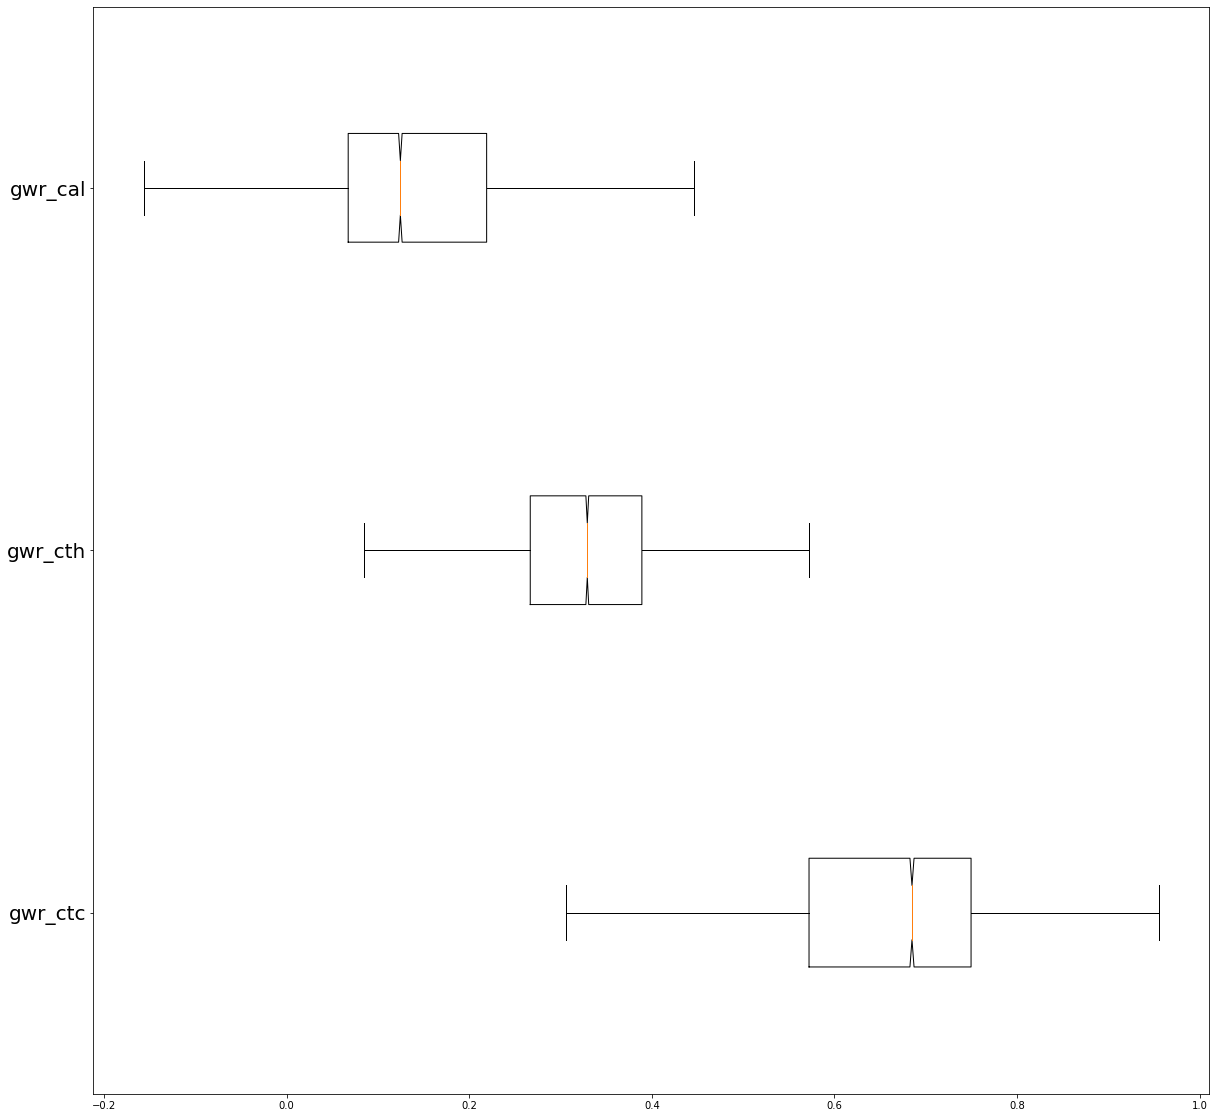

In [ ]:
#모델별 R2 분포 확인

plt.figure(figsize=(20, 20))
plt.boxplot([gwr_result_ctc.localR2.reshape(-1,),gwr_result_cth.localR2.reshape(-1,),gwr_result_cal.localR2.reshape(-1,)],
            vert=False, notch=True, sym="")
plt.gca().set_yticklabels(['gwr_ctc', 'gwr_cth', 'gwr_cal'],
                          rotation=0, fontsize=20)

> __각 모델의 R2이 OLS와 공간회귀분석보다 월등히 높으므로 GWR을 최종모델로 선정__

In [ ]:
#상수항을 첫번째 변수로 변경

name_X_ctc = [ 'const', 'traffic_total_sum_inter', 'crosswalk_ar','car_lane','cctv','restaurant_cnt','subway_cnt',
              'trlight_car','safe_zone','office','barrier_road','oneway','speed_40_to_50','width_1','intersects','width_2','trlight_pas','other',
              'express','freq_max_inter','pop_all','speed_30','noparking_ar']
name_X_cth = [ 'const','restaurant_cnt','crosswalk_ar','other','traffic_total_sum_inter','pop_all','car_lane','safe_zone',
              'trlight_car','ssm_cnt','parkinglot_cnt','speed_30','office','subway_cnt','oneway','cctv','noparking_ar','house','speed_40_to_50']

name_X_cal = ['const', 'traffic_total_sum_inter','trlight_car','cctv','other','subway_cnt','express','noparking_ar','school_cnt','width_2']

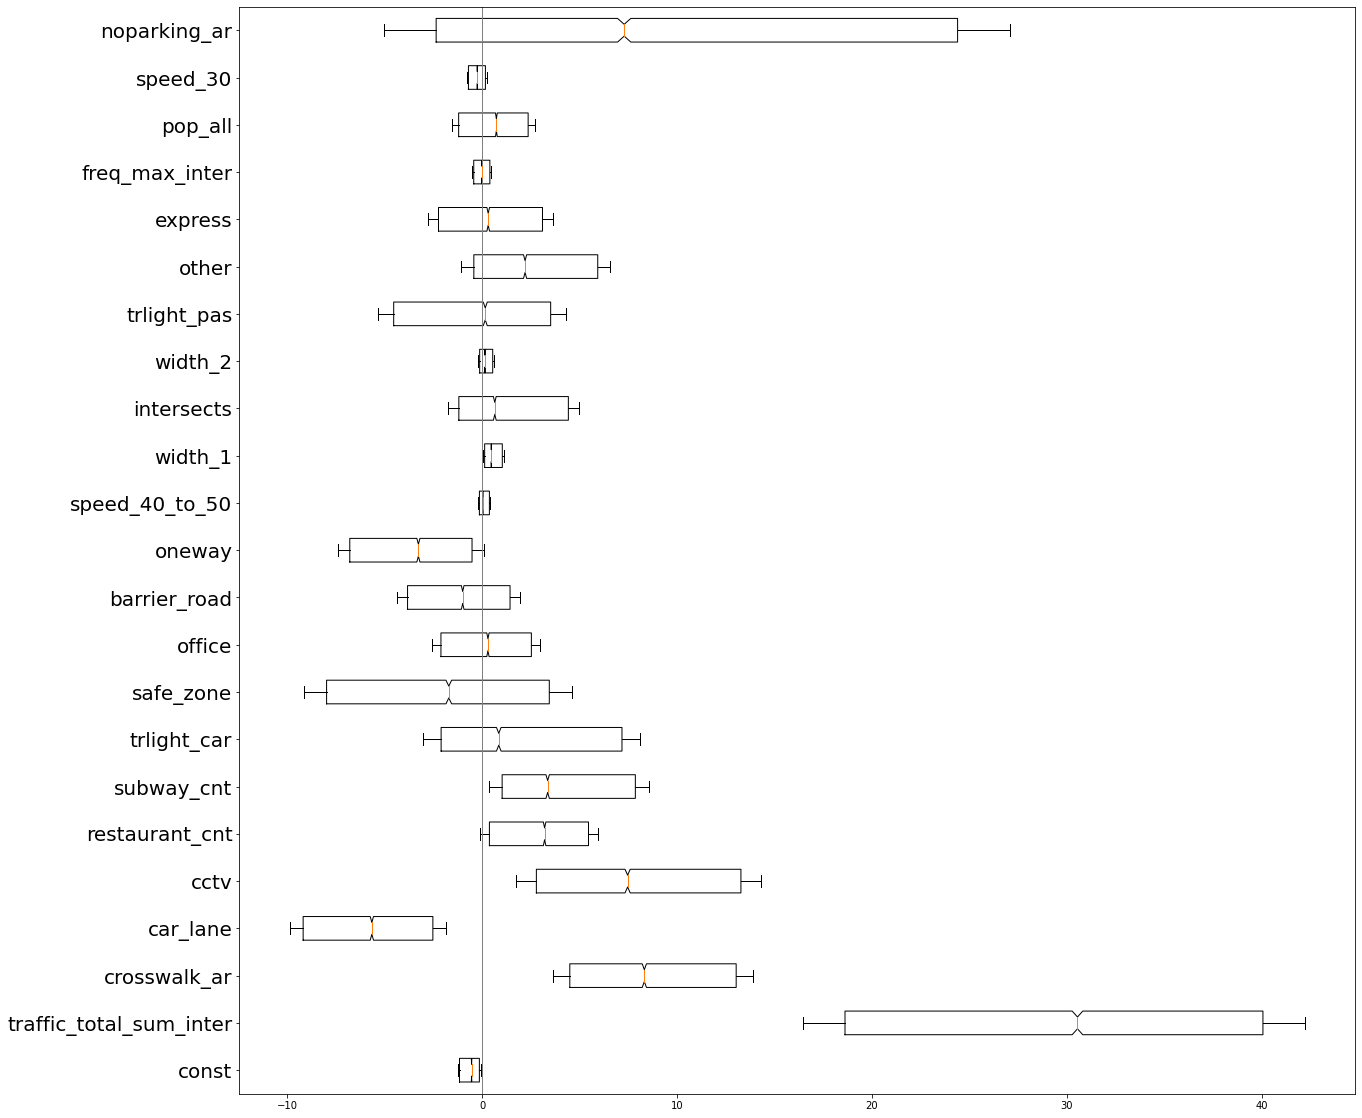

In [ ]:
#차대차 사고의 변수계수 분포

plt.figure(figsize=(20, 20))

plt.boxplot(
    [gwr_result_ctc.params[:,0], gwr_result_ctc.params[:,1], gwr_result_ctc.params[:,2], gwr_result_ctc.params[:,3],
     gwr_result_ctc.params[:,4], gwr_result_ctc.params[:,5], gwr_result_ctc.params[:,6], gwr_result_ctc.params[:,7],
     gwr_result_ctc.params[:,8], gwr_result_ctc.params[:,9], gwr_result_ctc.params[:,10], gwr_result_ctc.params[:,11],
     gwr_result_ctc.params[:,12], gwr_result_ctc.params[:,13], gwr_result_ctc.params[:,14], gwr_result_ctc.params[:,15],
     gwr_result_ctc.params[:,16], gwr_result_ctc.params[:,17], gwr_result_ctc.params[:,18], gwr_result_ctc.params[:,19],
     gwr_result_ctc.params[:,20], gwr_result_ctc.params[:,21], gwr_result_ctc.params[:,22]],
    vert=False,
    notch=True,
    sym="",
    whis=0.1)

plt.gca().set_yticklabels(name_X_ctc,
                          rotation=0, fontsize=20)

plt.axvline(0, 0, 1, color='grey', linewidth='1')

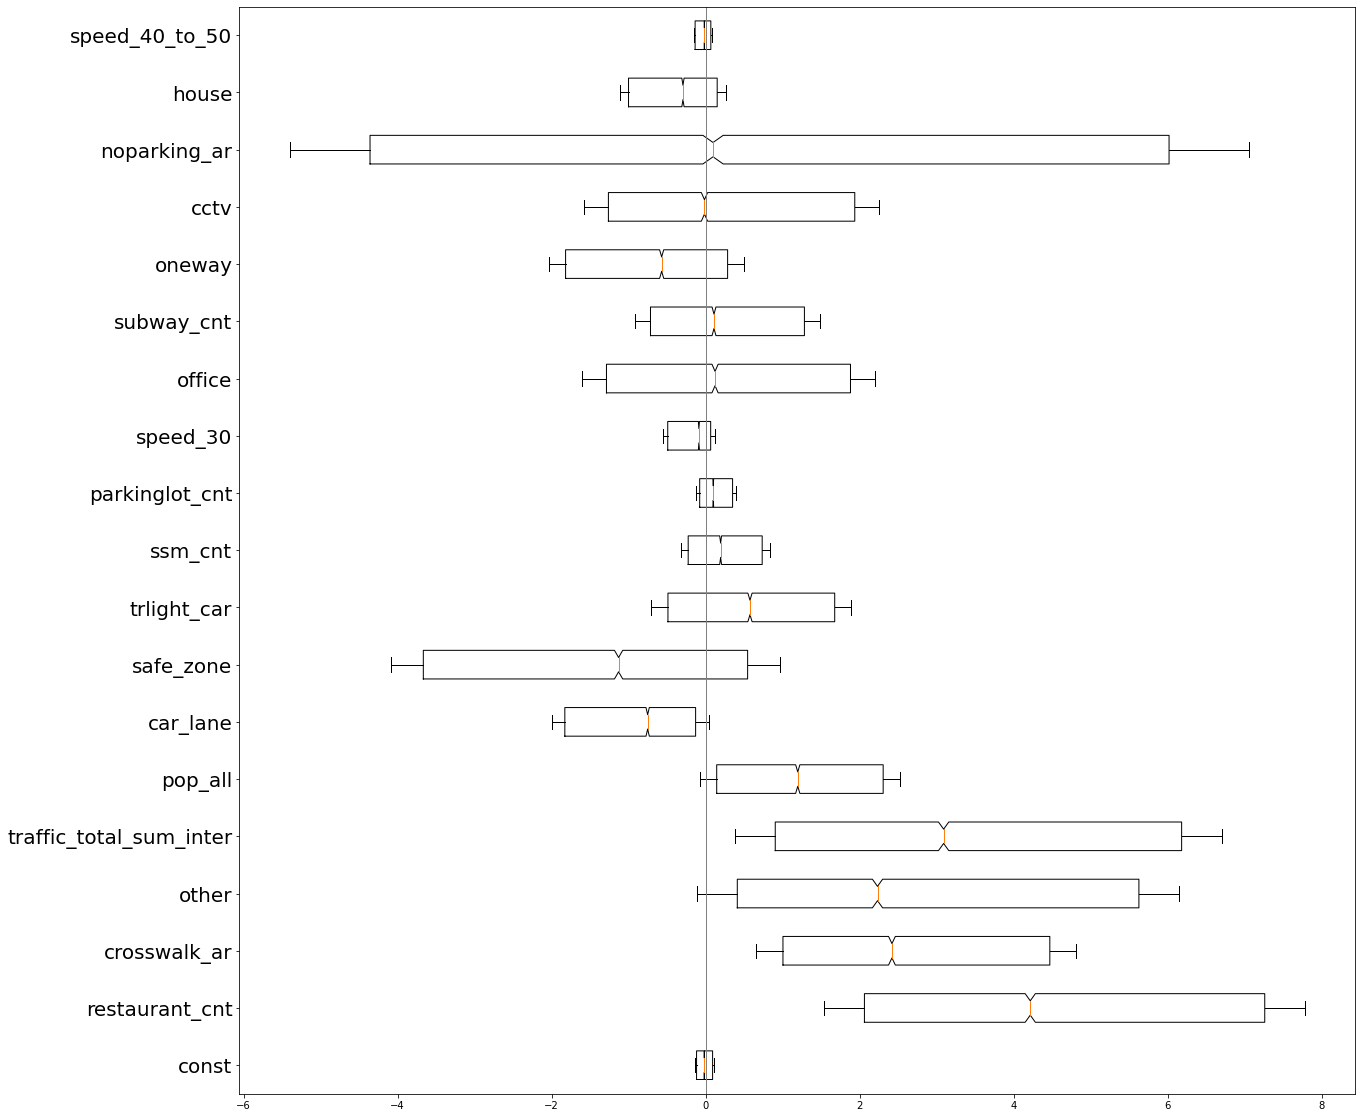

In [ ]:
#차대사람 사고의 변수계수 분포

plt.figure(figsize=(20, 20))

plt.boxplot(
    [gwr_result_cth.params[:,0], gwr_result_cth.params[:,1], gwr_result_cth.params[:,2], gwr_result_cth.params[:,3],
     gwr_result_cth.params[:,4], gwr_result_cth.params[:,5], gwr_result_cth.params[:,6], gwr_result_cth.params[:,7],
     gwr_result_cth.params[:,8], gwr_result_cth.params[:,9], gwr_result_cth.params[:,10], gwr_result_cth.params[:,11],
     gwr_result_cth.params[:,12], gwr_result_cth.params[:,13], gwr_result_cth.params[:,14], gwr_result_cth.params[:,15],
     gwr_result_cth.params[:,16], gwr_result_cth.params[:,17], gwr_result_cth.params[:,18]],
    vert=False,
    notch=True,
    sym="",
    whis=0.1)

plt.gca().set_yticklabels(name_X_cth,
                          rotation=0, fontsize=20)

plt.axvline(0, 0, 1, color='grey', linewidth='1')

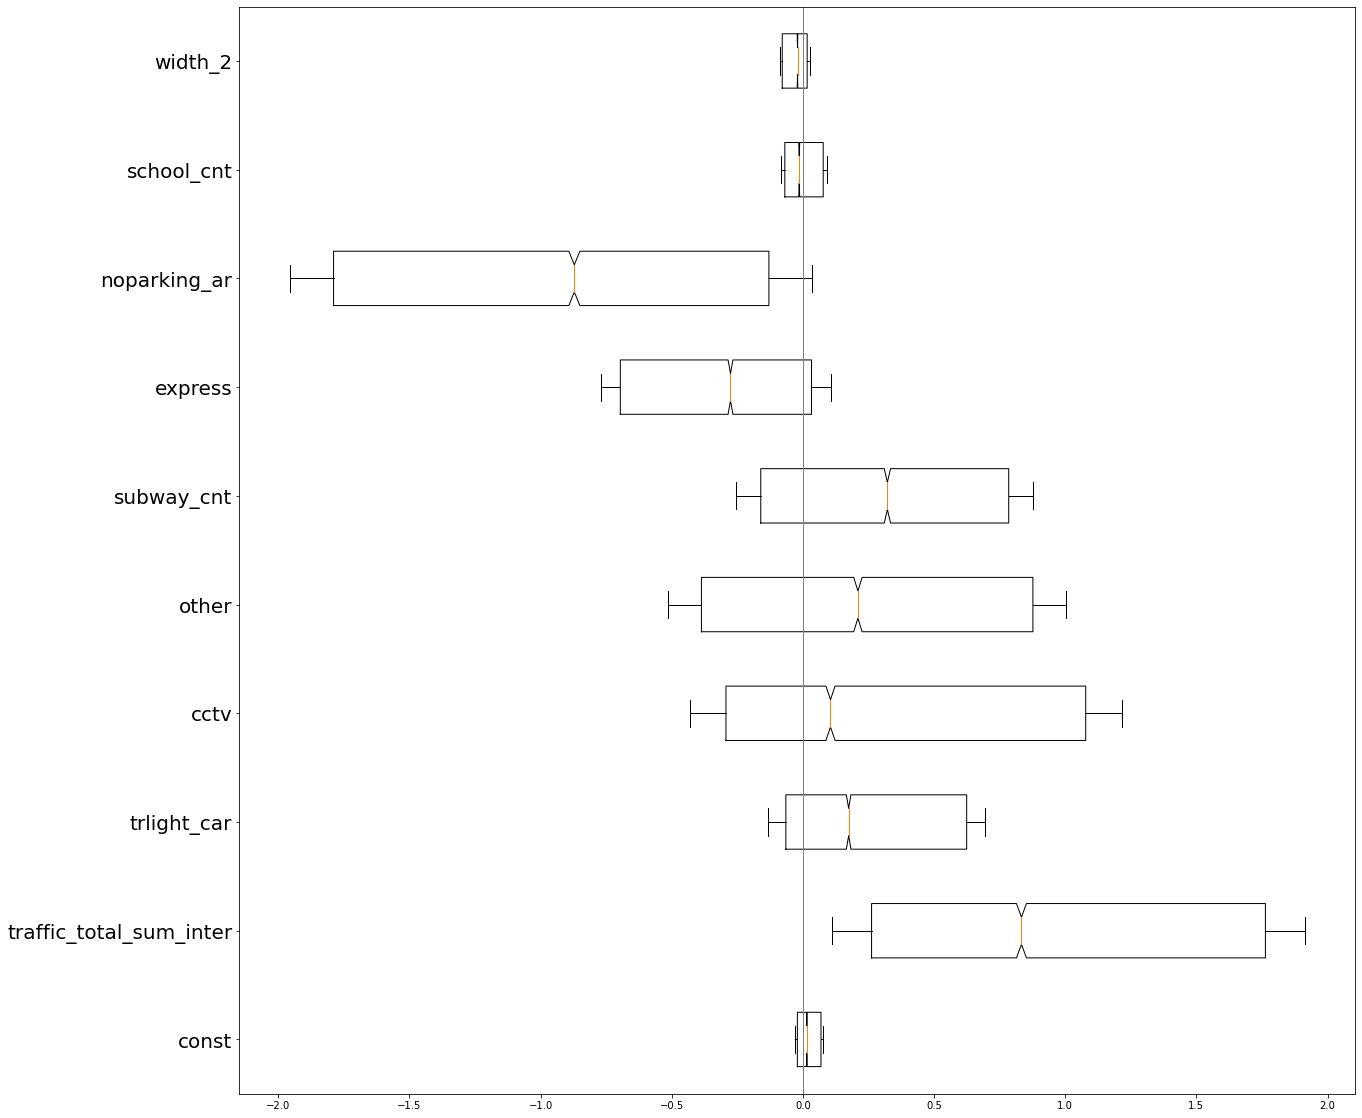

In [ ]:
#차량단독 사고의 변수계수 분포

plt.figure(figsize=(20, 20))

plt.boxplot(
    [gwr_result_cal.params[:,0], gwr_result_cal.params[:,1], gwr_result_cal.params[:,2], gwr_result_cal.params[:,3],
     gwr_result_cal.params[:,4], gwr_result_cal.params[:,5], gwr_result_cal.params[:,6], gwr_result_cal.params[:,7],
     gwr_result_cal.params[:,8], gwr_result_cal.params[:,9]],
    vert=False,
    notch=True,
    sym="",
    whis=0.1)

plt.gca().set_yticklabels(name_X_cal,
                          rotation=0, fontsize=20)

plt.axvline(0, 0, 1, color='grey', linewidth='1')